# Aereal Drone Image Segmentation through U-net architecture

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
#import imageio.v2 as io
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader
import torchsummary
from torchsummary import summary

device= "cuda" if torch.cuda.is_available() else "cpu"

In [51]:
dataset_path = r'E:\Datasets\drone_seg'
class_csv_path = os.path.join(dataset_path, r'class_dict_seg.csv')
original_images_path = os.path.join(dataset_path, r'dataset\semantic_drone_dataset\original_images')
rgb_masks_path = os.path.join(dataset_path, r'RGB_color_image_masks\RGB_color_image_masks')

#Get the image and mask fullpaths
original_images = os.listdir(original_images_path)
original_images_fullpath = [os.path.join(original_images_path, image_path) for image_path in original_images]
rgb_masks = os.listdir(rgb_masks_path)
rgb_masks_fullpath = [os.path.join(rgb_masks_path, mask_path) for mask_path in rgb_masks]

## EDA

### Labels

In [6]:
labels = pd.read_csv(class_csv_path)
labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [15]:
labels_dict = {name:list(labels.iloc[index,1:]) for index, name in enumerate(labels.name)}
labels_dict

{'unlabeled': [0, 0, 0],
 'paved-area': [128, 64, 128],
 'dirt': [130, 76, 0],
 'grass': [0, 102, 0],
 'gravel': [112, 103, 87],
 'water': [28, 42, 168],
 'rocks': [48, 41, 30],
 'pool': [0, 50, 89],
 'vegetation': [107, 142, 35],
 'roof': [70, 70, 70],
 'wall': [102, 102, 156],
 'window': [254, 228, 12],
 'door': [254, 148, 12],
 'fence': [190, 153, 153],
 'fence-pole': [153, 153, 153],
 'person': [255, 22, 96],
 'dog': [102, 51, 0],
 'car': [9, 143, 150],
 'bicycle': [119, 11, 32],
 'tree': [51, 51, 0],
 'bald-tree': [190, 250, 190],
 'ar-marker': [112, 150, 146],
 'obstacle': [2, 135, 115],
 'conflicting': [255, 0, 0]}

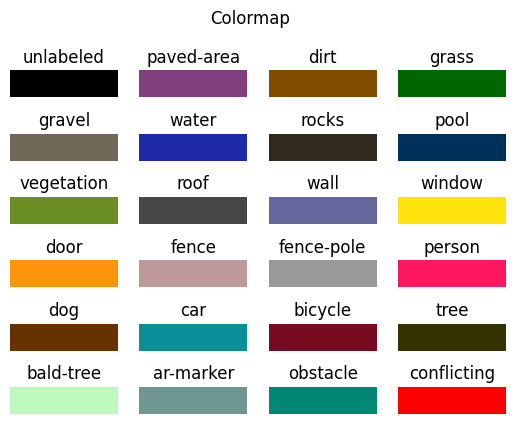

In [33]:
def print_colors_map(labels):
    for i, data in enumerate(labels):
        rgb = labels[data]
        plt.subplot(6,4,i+1)
        color_image = np.array([[rgb,rgb,rgb,rgb]])
        plt.title(data)
        plt.imshow(color_image)
        plt.axis('off')
        plt.suptitle('Colormap')

print_colors_map(labels_dict)

### Images

In [41]:
print(f'Total images: {len(original_images_fullpath)} - Total masks: {len(rgb_masks_fullpath)}')
print(original_images_fullpath[:2])
print(rgb_masks_fullpath[:2])

Total images: 400 - Total masks: 400
['E:\\Datasets\\drone_seg\\dataset\\semantic_drone_dataset\\original_images\\000.jpg', 'E:\\Datasets\\drone_seg\\dataset\\semantic_drone_dataset\\original_images\\001.jpg']
['E:\\Datasets\\drone_seg\\RGB_color_image_masks\\RGB_color_image_masks\\000.png', 'E:\\Datasets\\drone_seg\\RGB_color_image_masks\\RGB_color_image_masks\\001.png']


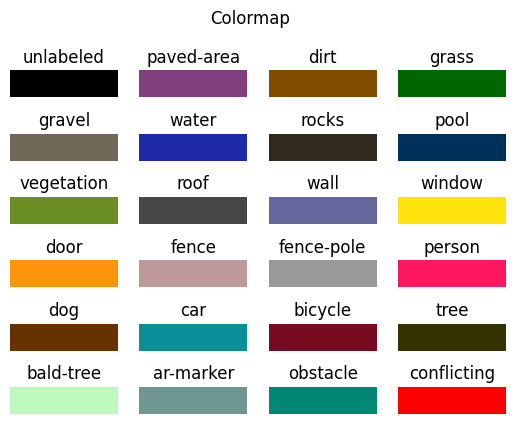

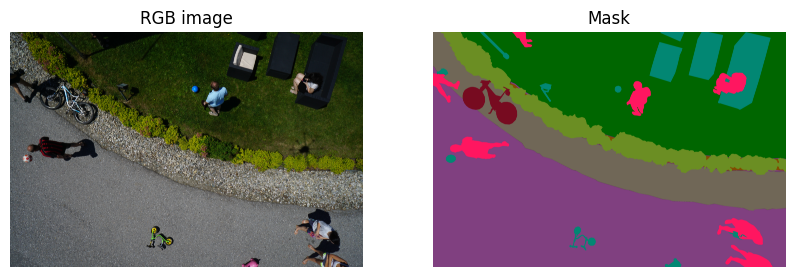

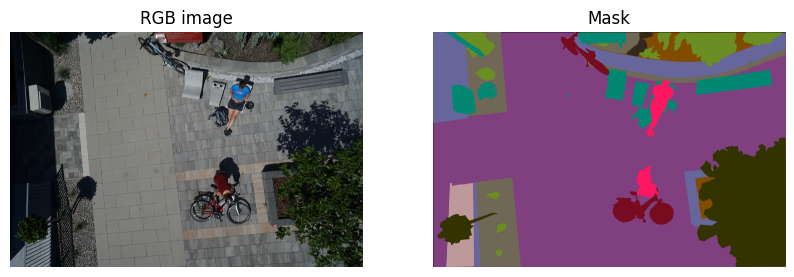

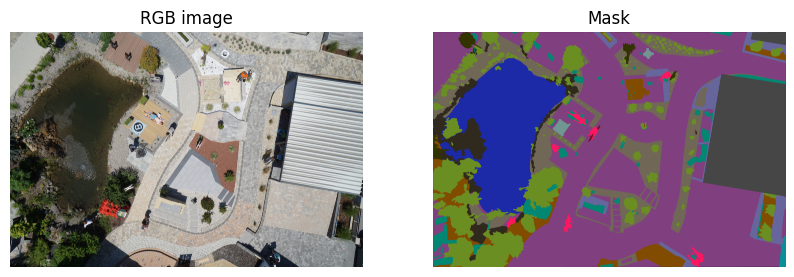

In [47]:
def plot_single_image_and_mask(img,mask):
    _, axs = plt.subplots(1,2,figsize=(10,10))
    axs[0].imshow(img)
    axs[0].set_title('RGB image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    axs[0].axis('off')
    axs[1].axis('off')

def plot_image_and_mask(imgs_path, masks_path, n=3):
    for _ in range(n):
        i = np.random.randint(0, len(imgs_path))
        img = io.imread(imgs_path[i])
        mask = io.imread(masks_path[i])
        plot_single_image_and_mask(img,mask) 

print_colors_map(labels_dict)
plot_image_and_mask(original_images_fullpath, rgb_masks_fullpath)

## Dataset and Dataloader

torch.Size([10, 3, 1000, 1500]) torch.Size([10, 3, 1000, 1500])


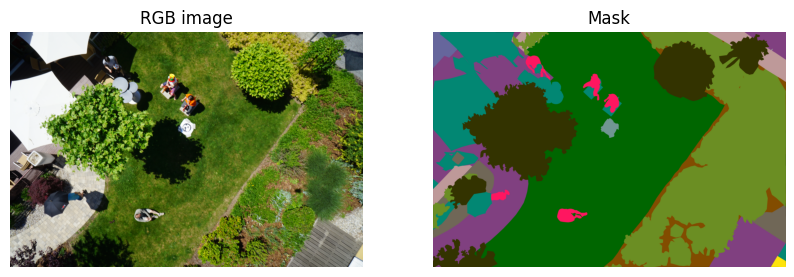

In [106]:
def plot_tensor_image(image, title, figsize=(10,10)):
    image = image[0].permute(1, 2, 0).numpy()
    fig = plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.title = title
    plt.axis('off')
    plt.show()

class CustomDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, rotation_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.rotation_transform = rotation_transform
    
    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, idx):
        img_path = self.images_dir[idx]
        mask_path = self.masks_dir[idx]
        
        image = io.read_image(img_path)
        mask = io.read_image(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

class RandomRotationTransform():
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img, mask):
        angle = np.random.uniform(-self.degrees, self.degrees)
        return transforms.functional.rotate(img, angle), transforms.functional.rotate(mask, angle)


# Image transformation: Original image aspect ratio is 1.5
transform = transforms.Compose([
    transforms.Resize((800, 1200), antialias=True),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and Dataloader
dataset = CustomDataset(images_dir=original_images_fullpath,
                        masks_dir=rgb_masks_fullpath,
                        transform=transform,
                        rotation_transform=RandomRotationTransform(180))

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterar sobre el dataloader
for images, masks in dataloader:
    print(images.shape, masks.shape)
    plot_single_image_and_mask(images[0].permute(1, 2, 0).numpy(), masks[0].permute(1, 2, 0).numpy())
    break

## U-net architecture

In [8]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d((2, 2)),
            #nn.Dropout2d(0.25),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.start = (DoubleConv(n_channels, 64))
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256) 
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.finish = OutConv(64, n_classes)

    def forward(self, x):
        # x = [bz,3,800,1200]
        x1 = self.start(x) # [bz,64,800,1200]
        x2 = self.down1(x1) # [bz,128,400,600]
        x3 = self.down2(x2) # [bz,256,200,300]
        x4 = self.down3(x3) # [bz,512,100,150]
        x5 = self.down4(x4) # [bz,1024,50,75]

        y4 = self.up1(x5, x4) # [bz,512,100,150]
        y3 = self.up2(y4, x3) # [bz,256,200,300]
        y2 = self.up3(y3, x2) # [bz,128,400,600]
        y1 = self.up4(y2, x1) # [bz,1024,800,1200]
        y =  self.finish(y1)

        return y

# n_channels=3 for RGB images
model = UNet(n_channels=3, n_classes=3)
model = model.to(device)

summary(model, (3, 800, 1200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 800, 1200]           1,792
       BatchNorm2d-2        [-1, 64, 800, 1200]             128
              ReLU-3        [-1, 64, 800, 1200]               0
            Conv2d-4        [-1, 64, 800, 1200]          36,928
       BatchNorm2d-5        [-1, 64, 800, 1200]             128
              ReLU-6        [-1, 64, 800, 1200]               0
        DoubleConv-7        [-1, 64, 800, 1200]               0
         MaxPool2d-8         [-1, 64, 400, 600]               0
            Conv2d-9        [-1, 128, 400, 600]          73,856
      BatchNorm2d-10        [-1, 128, 400, 600]             256
             ReLU-11        [-1, 128, 400, 600]               0
           Conv2d-12        [-1, 128, 400, 600]         147,584
      BatchNorm2d-13        [-1, 128, 400, 600]             256
             ReLU-14        [-1, 128, 4